# Load Data

In [1]:
import seaborn as sns
sns.set()
import re

In [2]:
import pandas as pd

df = pd.read_csv("../data/album_age_ratings.csv")
print ("Columns of df: ",  list(enumerate(df.columns)), "\n")

print ("Shape of df: ", df.shape, "\n")

print ("Number of albums having description: ", df['Description'].notnull().sum(), "\n")

df.head(3)

Columns of df:  [(0, 'Title'), (1, 'Age'), (2, 'Age Group'), (3, 'Artist'), (4, 'Year'), (5, 'Description')] 

Shape of df:  (2206, 6) 

Number of albums having description:  2206 



,Title,Age,Age Group,Artist,Year,Description
0,Sesame Street: Halloween Collection,2,Toodler,Sesame Street,2012,"Playful, not-so-spooky Halloween songs for th..."
1,A Child's Celebration of Rock 'n' Roll,2,Toodler,Various Artists,1996,Songs to get toddlers and teens energized.
2,Wake up Jeff,2,Toodler,The Wiggles,2000,Songs and scenes certain to keep kids attenti...


In [3]:
#df[df['Description'].apply(lambda x: 'clean' in x.lower())][['Age','Title','Description']]

pd.set_option("max_colwidth", 150)
df[df['Description'].str.contains('[C|c]lean', regex=True)][['Age','Title','Description']]


,Age,Title,Description
34,2,Victor Vito,Clean but bland blend of familiar and new songs.
276,3,"""Just Like a Rockstar"" (CD Single)","Teamwork takes center stage in this cute, clean tune."
419,5,Muppets: The Green Album,"Cool, modern remakes of classic, clean Muppet tunes."
421,5,The Muppets Soundtrack,"Super-clean, cute soundtrack has something for everyone."
450,6,Cheetah-licious Christmas,Good clean Christmas fun!
...,...,...,...
1843,14,"""Super Bass"" (CD Single)","Minaj keeps it cleaner than usual, but song is still mature."
1886,14,"""Holy Grail (feat. Justin Timberlake)"" (CD Single)",Superstar team-up is explicit; clean version OK for teens.
1983,15,F.A.M.E.,"R&B songs run gamut from clean to extremely dirty, mature."
1993,15,"""Strange Clouds"" (CD Single)",Unusually explicit song from typically clean rapper.


# Text Processing

In [4]:
import spacy
nlp = spacy.load("en", disable=['parser','ner','tagger', 'textcat'])

In [5]:
import re

def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if w.lemma_ not in ['_', '.', '-PRON-'] ]

stopwords = spacy.lang.en.stop_words.STOP_WORDS.union(['song', 'album','cd', 'music', 'track','tune'])

stopwords = set(my_lemmatizer(' '.join(list(stopwords))))

# Bag-of-Words Model + K-Mean clustering

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer(tokenizer=my_lemmatizer, stop_words=stopwords, ngram_range=(1,1),
                     min_df=2, max_df=0.95)
counts = cv.fit_transform(df['Description'])

tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

In [7]:
import random   
random.sample(list(cv.get_feature_names_out()), 10)    #random select 10 words from CountVectorizer

['lyrical',
 'pain',
 'steamy',
 'rise',
 'hunger',
 'sweetheart',
 'fantastic',
 'promote',
 'turn',
 'english']

In [8]:
from sklearn.cluster import KMeans
number_of_clusters = 5

kmc_5 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)  # random_state for consistency
kmc_5.fit(matrix)

import numpy as np

number_of_top_words = 10

cluster_words = np.argsort(kmc_5.cluster_centers_, axis=1)
terms = cv.get_feature_names_out()

top_words = set()

print ("Words listed in decreasing order of tf-idf \n")

for i in range(number_of_clusters):
    print('Cluster {}: '.format(i))
    print(', '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]][::-1]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

Words listed in decreasing order of tf-idf 

Cluster 0: 
clean, pop, love, dance, country, idol, squeaky, star, fun, catchy 

Cluster 1: 
fun, teen, sex, love, message, family, sexy, sweet, soundtrack, classic 

Cluster 2: 
kid, friendly, young, fun, okay, old, movie, parent, enjoy, great 

Cluster 3: 
rock, alt, indie, pop, clean, roll, classic, punk, kid, teen 

Cluster 4: 
mature, explicit, old, teen, rap, theme, clean, okay, message, content 



In [9]:
word_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
word_df['Cluster'] = kmc_5.labels_.tolist()
word_df.head(3)

,alt,catchy,classic,clean,content,country,dance,enjoy,explicit,family,...,sex,sexy,soundtrack,squeaky,star,sweet,teen,theme,young,Cluster
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [10]:
df['knn_cluster'] = word_df['Cluster']

In [11]:
df.head(5)

,Title,Age,Age Group,Artist,Year,Description,knn_cluster
0,Sesame Street: Halloween Collection,2,Toodler,Sesame Street,2012,"Playful, not-so-spooky Halloween songs for the family.",1
1,A Child's Celebration of Rock 'n' Roll,2,Toodler,Various Artists,1996,Songs to get toddlers and teens energized.,1
2,Wake up Jeff,2,Toodler,The Wiggles,2000,Songs and scenes certain to keep kids attentive.,2
3,Toot Toot!,2,Toodler,The Wiggles,2001,Gets little couch potatoes up and moving.,1
4,A Child's Celebration of Classical Music,2,Toodler,Various Artists,1999,Talented celebs promote classics for kids.,2


In [12]:
word_df.groupby('Cluster').size()

Cluster
0     412
1    1278
2     220
3     156
4     140
dtype: int64

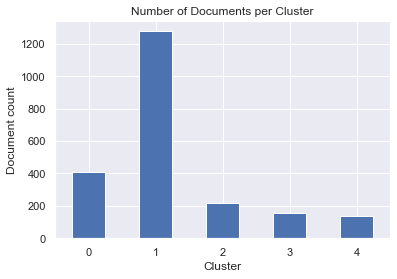

In [13]:
(word_df.groupby('Cluster').size().
    plot.bar(rot=0).
    set(ylabel='Document count',
    title='Number of Documents per Cluster'));

# Latent Dirichlet allocation (LDA)

In [14]:
import gensim

import re
def process_words(texts, stop_words=set()):
    result = []
    for t in texts:
        t = ' '.join(re.findall(r'\b\w[\w\']+\b', t))
        doc = nlp(t)
        result.append([token.lemma_.lower() for token in doc if token.lemma_.lower() not in stop_words])
    return result

processed_text = process_words(df['Description'], stop_words=stopwords.union(['-PRON-','song','album','cd','track','music']))

In [30]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))
corpus = [dictionary.doc2bow(t) for t in processed_text]
num_topics = 6


lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=117, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)
"""

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=117)
"""


Number of unique tokens: 2458


'\n\nlda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, \n                                            id2word=dictionary,\n                                            num_topics=num_topics, \n                                            random_state=117)\n'

In [31]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=5))

[(0, '0.033*"teen" + 0.029*"kid" + 0.021*"clean" + 0.018*"rock" + 0.016*"fun"'),
 (1,
  '0.033*"pop" + 0.023*"graphic" + 0.019*"punk" + 0.017*"love" + '
  '0.016*"violent"'),
 (2,
  '0.060*"pop" + 0.040*"drink" + 0.037*"dance" + 0.031*"club" + 0.025*"party"'),
 (3,
  '0.119*"rap" + 0.061*"message" + 0.049*"sex" + 0.039*"iffy" + '
  '0.036*"content"'),
 (4,
  '0.089*"single" + 0.070*"clean" + 0.056*"band" + 0.041*"catchy" + '
  '0.027*"well"'),
 (5,
  '0.150*"sex" + 0.094*"explicit" + 0.062*"party" + 0.059*"profanity" + '
  '0.043*"heavy"')]


In [49]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join([x[0] for x in model.show_topic(topic)]))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)
    #result_df = pd.concat([result_df, df['Description']], axis=1)

    return result_df

In [50]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)
main_topic_df = pd.concat([df.drop(columns=['Age Group','Artist','Year']), 
                           main_topic_df[['Processed_text','Dominant_topic','Percent','Keywords']]], axis=1)

main_topic_df.head(10)


,Title,Age,Description,knn_cluster,Processed_text,Dominant_topic,Percent,Keywords
0,Sesame Street: Halloween Collection,2,"Playful, not-so-spooky Halloween songs for the family.",1,"[playful, spooky, halloween, family]",3,0.423,rap message sex iffy content positive lyric super bore talk
1,A Child's Celebration of Rock 'n' Roll,2,Songs to get toddlers and teens energized.,1,"[songs, toddler, teen, energize]",0,0.856,teen kid clean rock fun ok old pop mature young
2,Wake up Jeff,2,Songs and scenes certain to keep kids attentive.,2,"[songs, scene, certain, kid, attentive]",0,0.881,teen kid clean rock fun ok old pop mature young
3,Toot Toot!,2,Gets little couch potatoes up and moving.,1,"[gets, couch, potato]",0,0.823,teen kid clean rock fun ok old pop mature young
4,A Child's Celebration of Classical Music,2,Talented celebs promote classics for kids.,2,"[talented, celebs, promote, classic, kid]",0,0.882,teen kid clean rock fun ok old pop mature young
5,A Child's Celebration of Dance Music,2,Guaranteed dance-crowd pleasers.,1,"[guaranteed, dance, crowd, pleaser]",0,0.844,teen kid clean rock fun ok old pop mature young
6,A Child's Celebration of Song 2,2,Decades-old songs made fresh for kids.,2,"[decades, old, fresh, kid]",5,0.784,sex explicit party profanity heavy video relationship brit kid reference
7,The Best of Elmo,2,Sesame Street fans love Elmo's fun-filled songs.,1,"[sesame, street, fan, love, elmo, fun, fill]",0,0.911,teen kid clean rock fun ok old pop mature young
8,Fiesta Songs!,2,Parents may enjoy the music as much as their kids.,2,"[parents, enjoy, kid]",0,0.823,teen kid clean rock fun ok old pop mature young
9,Uni Verse of Song-French,2,Excellent French/English sing-along.,1,"[excellent, french, english, sing]",0,0.858,teen kid clean rock fun ok old pop mature young


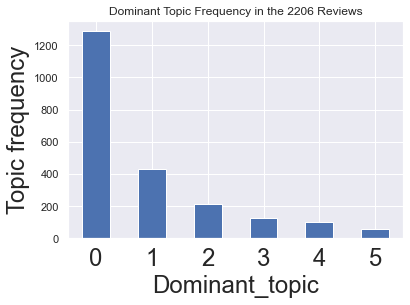

In [51]:
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title='Dominant Topic Frequency in the {} Reviews'.format(len(df)),
        ylabel='Topic frequency'); 

In [52]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(1) ])
    
representatives.drop(columns=['Processed_text'])

,Title,Age,Description,knn_cluster,Dominant_topic,Percent,Keywords
1280,Love IS,12,"Idol's ""Velvet Teddy Bear"" offers clean, gospel-tinged CD.",0,0,0.921,teen kid clean rock fun ok old pop mature young
970,Highlights From the Complete Soundtrack of American Graffiti,10,"Small-town, early '60s innocence frozen in time forever.",1,1,0.912,pop graphic punk love violent clean lyric rock word language
561,"""Heard It on the Radio"" (CD Single)",7,Austin & Ally star cuts clean track about a fun beach party.,0,2,0.903,pop drink dance club party sexy rock beat star clean
160,Picnic Playgound,2,Putumayo Kids serves up a colorful mix of tasty treats.,2,3,0.890,rap message sex iffy content positive lyric super bore talk
757,"""Pompeii"" (CD single)",9,British band's single about famous city's fall stays clean.,0,4,0.897,single clean band catchy well smooth teens bite classic sensation
1294,"""Didn't You Know How Much I Loved You"" (CD single)",12,Jilted lover's revenge invokes the bedroom but stays tame.,1,5,0.886,sex explicit party profanity heavy video relationship brit kid reference


In [36]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive


def f(idx):
    print('Document: {}  Dominant topic: {}\n'.format(representatives.index[idx], 
                                       representatives.loc[representatives.index[idx]]['Dominant_topic']))
    print(df['Description'][representatives.index[idx]])

    
interactive(f, idx = widgets.Dropdown(options=range(num_topics), value=0, description='topic id'))

interactive(children=(Dropdown(description='topic id', options=(0, 1, 2, 3, 4, 5), value=0), Output()), _dom_c…

### Topic words destribution per topic 

In [37]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)[0:5]])

print('Indices of top words: \n{}\n'.format(lda_top_words_index))

Indices of top words: 
{962, 131, 6, 10, 74, 202, 1356, 1358, 912, 20, 278, 1752, 793, 29, 30, 1762, 418, 1381, 296, 1772, 173, 115, 1270, 1207, 507, 63}



In [38]:
lda_model.get_topic_terms(2)

[(74, 0.059604354),
 (1207, 0.040176734),
 (20, 0.036646508),
 (962, 0.031089649),
 (63, 0.025270768),
 (1292, 0.025252124),
 (202, 0.02261976),
 (655, 0.02158346),
 (104, 0.018632093),
 (115, 0.016890507)]

In [39]:
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]

In [40]:
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

In [41]:
lda_top_words_df.columns

Index(['band', 'catchy', 'clean', 'club', 'content', 'dance', 'drink',
       'explicit', 'fun', 'graphic', 'heavy', 'iffy', 'kid', 'love', 'message',
       'party', 'pop', 'profanity', 'punk', 'rap', 'rock', 'sex', 'single',
       'teen', 'violent', 'well', 'Cluster'],
      dtype='object')

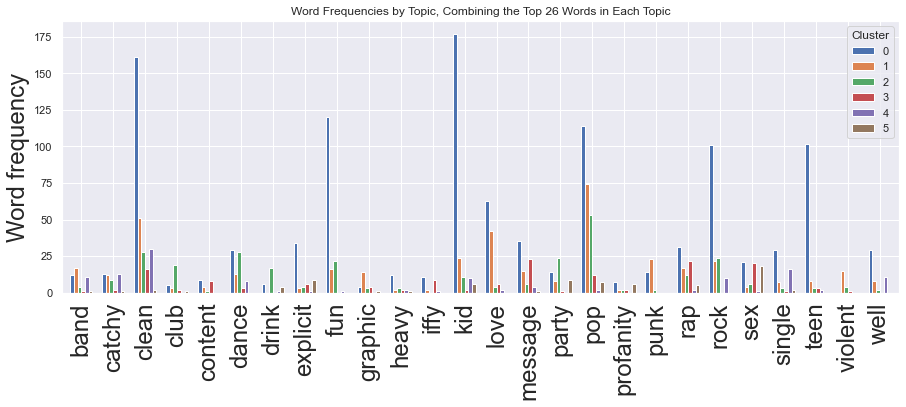

In [42]:

import matplotlib.pyplot as plt

plt.rc('axes', labelsize=24) 
plt.rc('xtick', labelsize=24) 


lda_top_words_df.groupby('Cluster').sum().transpose().\
         plot.bar(figsize=(15, 5), width=0.7).\
         set(ylabel='Word frequency', 
         title='Word Frequencies by Topic, Combining the Top {} Words in Each Topic'.format(len(lda_top_words_index)));

In [43]:
lda_top_words_df.groupby('Cluster').sum().iloc[[1,2,3,4,5]]

,band,catchy,clean,club,content,dance,drink,explicit,fun,graphic,...,pop,profanity,punk,rap,rock,sex,single,teen,violent,well
Cluster,,,,,,,,,,,,,,,,,,,,,
1,17,12,51,3,4,13,0,3,16,14,...,74,2,23,17,22,4,7,8,15,8
2,4,9,28,19,1,28,17,4,22,3,...,53,2,2,12,24,6,3,3,4,2
3,1,2,16,2,8,3,0,6,0,4,...,12,2,0,22,0,20,1,3,1,0
4,11,13,30,0,0,8,1,1,1,0,...,2,0,0,2,10,1,16,2,0,11
5,1,1,2,1,0,0,4,9,0,1,...,7,6,0,5,0,18,2,0,0,0


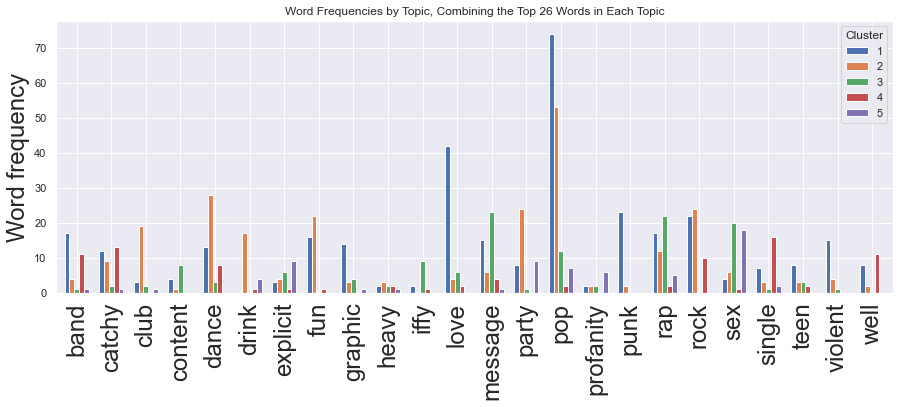

In [44]:
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=24) 
plt.rc('xtick', labelsize=24) 

lda_top_words_df.groupby('Cluster').sum().iloc[[1,2,3,4,5]].drop(columns=['clean','kid']).transpose().\
         plot.bar(figsize=(15, 5), width=0.7).\
         set(ylabel='Word frequency', 
         title='Word Frequencies by Topic, Combining the Top {} Words in Each Topic'.format(len(lda_top_words_index)));



### Number of Topics

In [45]:
cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model,
                                                 texts=processed_text,
                                                 dictionary=dictionary)

coherence_scores = [(num_topics, cm.get_coherence())]
print('Coherence score for {} topics:  {}'.format(*coherence_scores[0]))

Coherence score for 6 topics:  0.4639508936496488


In [46]:
coherence_scores = []
for n in range(4, 20):
    mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=processed_text,
                                                 dictionary=dictionary)
    coherence_scores.append((n, cmodel.get_coherence()))

coherence_scores

[(4, 0.4119012387246631),
 (5, 0.45838042508682886),
 (6, 0.4639508936496488),
 (7, 0.4751209671822399),
 (8, 0.5027893838233537),
 (9, 0.5015018937843336),
 (10, 0.4939042899301721),
 (11, 0.5198487864048752),
 (12, 0.5063204507990501),
 (13, 0.5328261420654614),
 (14, 0.5194699654333372),
 (15, 0.521320137604544),
 (16, 0.5270601266031287),
 (17, 0.5332656970289977),
 (18, 0.5465781390551996),
 (19, 0.5525245997285361)]